This is a notebook to simulate Tax Loss Harvesting for US taxes.

In [1]:
# Code from http://www.goddardconsulting.ca/matlab-monte-carlo-assetpaths-corr.html. Translated from MatLab
import cupy as cp
import math
def AssetPathsCorrelated(S0, mu, sig, corr, dt, steps, nsims):
    nAssets = len(S0)
    nu = mu-(sig**2)/2
    R = cp.linalg.cholesky(corr).T
    S = cp.empty((steps+1, nsims, nAssets))
    for idx in range(nsims):
        x = cp.random.standard_normal((steps, nAssets))
        ep = x@R
        S[:, idx, :] = cp.concatenate((cp.ones((1, nAssets)), cp.cumprod(cp.exp(cp.tile(nu*dt, (steps, 1))+ep@cp.diag(sig)*math.sqrt(dt)), axis = 0)))@cp.diag(S0)
    
    if nsims == 1:
        S = cp.squeeze(S)
    return S

In [2]:
# Example usage of AssetPathsCorrelated
S0 = cp.array([100, 100])
mu = cp.array([.3, .3])
sig = cp.array([.4, .4])
corr = cp.array([[1, .95], [.95, 1]])
dt = 1/365
etime = 2500
nsims = 100
S = AssetPathsCorrelated(S0, mu, sig, corr, dt, etime, nsims)

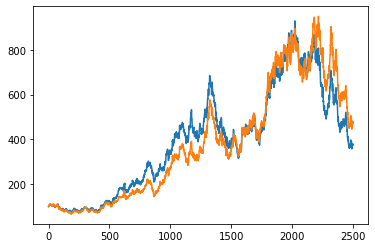

In [3]:
# Plot the first sim...
import matplotlib.pyplot as plt
plt.plot(S[:, 0, 0].get())
plt.plot(S[:, 0, 1].get());

In [4]:
#  We will immport some real data to help generate some realistic data.
import cudf
m1 = cudf.read_csv("MVO3.2021.11/NASDAQ/prices.csv")
m2 = cudf.read_csv("MVO3.2021.11/NYSE/prices.csv")
m = cudf.concat([m1, m2], axis = 1)
m = m.values

In [5]:
nAssets = m.shape[0] - 1  # Need num_obs > nAssets; otherwise cholesky returns null vals
indices = cp.random.choice(m.shape[1], nAssets, replace = False)

# Update values
m = m[:, indices]
corrInit = cp.corrcoef(m, rowvar = False)
S0 = cp.ones(nAssets) * 10000  # Starting price
muInit = cp.ones(nAssets) * 0.065  # 0.015 dividend annually
sigInit = cp.ones(nAssets) * 0.15

dt = 1 / 252  # Split into daily
steps = 6 * 252  # 6 years of data
nsims = 100  # 5 simulations to start
S = AssetPathsCorrelated(S0, muInit, sigInit, corrInit, dt, steps, nsims)
#(days, sims, assets)

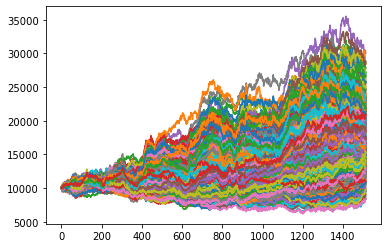

In [6]:
# Plot the first simulation
for i in range(nAssets):
    plt.plot(S[:, 0, i].get());

In [7]:
# Clear memory
del m, m1, m2

In [8]:
# We will use the first year for training, and the last five for testing
split = 252 * 1
train = S[:split, :, :]
test = S[split:, :, :]


logRet = cp.log(S[1:, :, :] / S[:-1, :, :])
logRetTrain = logRet[:split, :, :]
logRetTest = logRet[split + 1:, :, :]

covTrain = cp.empty((nsims, nAssets, nAssets))
covTest = cp.empty((nsims, nAssets, nAssets))
corrTrain = cp.empty((nsims, nAssets, nAssets))

for sim in range(nsims):
    covTrain[sim, :, :] = cp.cov(logRetTrain[:, sim, :], rowvar = False) * 252
    covTest[sim, :, :] = cp.cov(logRetTest[:, sim, :], rowvar = False) * 252
    corrTrain[sim, :, :] = cp.corrcoef(train[:, sim, :], rowvar = False)


In [9]:
# Let's generate some portfolios:
from HRP import HRP

W_HRP = cp.zeros((nsims, nAssets))
for sim in range(nsims):
    W_HRP[sim, :] = HRP(covTrain[sim, :, :], corrTrain[sim, :, :])

Iterations: 0
6048,127,209,2,0,0
Label prop iterations: 8
Iterations: 1
3822,125,74,3,179,694
Label prop iterations: 6
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 2
Iterations: 4
3588,334,187,5,763,1893
Label prop iterations: 2
Iterations: 1
3574,123,71,2,152,274
Iterations: 0
6319,104,92,2,0,0
Label prop iterations: 10
Iterations: 1
3583,124,74,2,161,826
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
3782,311,185,6,657,1694
Label prop iterations: 2
Iterations: 1
3791,265,182,2,184,301
Iterations: 0
13147,266,234,2,0,0
Label prop iterations: 7
Iterations: 1
7748,261,164,2,217,1601
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 3
Label prop iterations: 3
Iterations: 4
7453,450,286,5,808,2224
Label prop iterations: 2
Iterations: 1
7890,184,112,2,208,380
Iterations: 0
16758,139,385,2,0,0
Label prop iterations: 10
Iterations: 1
9890,230,153,5,304,1376
Label prop iterati

In [10]:
def rebalanceBuy(W_opt, W_curr, rate):
    #  We wish to rebalance a portfolio occasionally in order to keep our weights as optimal as possible. 
    #  W_opt is of the form cp array of size (nAssets). This is the optimal weighting
    #  W_curr is of the form cp array of size (nAssets). This is the current weighting
    #  rate is a float. If rate is 0.05, then we have 5% extra value to buy
    W_opt = W_opt.copy()*(1+rate)
    W_diff = W_opt - W_curr
    order = cp.flip(cp.argsort(W_diff))  # Sort by largest to smallest
    W_diff_sort = W_diff[order]
    to_buy = cp.zeros(len(W_opt))
    idx = 0
    while rate > 0:
        amt = min(W_diff_sort[idx], rate)
        to_buy[order[idx]] = amt
        rate -= amt
        idx += 1
    return to_buy

In [11]:
def rebalanceSell(W_opt, W_curr, rate):
    #  We wish to rebalance a portfolio occasionally in order to keep our weights as optimal as possible. 
    #  W_opt is of the form cp array of size (nAssets). This is the optimal weighting
    #  W_curr is of the form cp array of size (nAssets). This is the current weighting
    #  rate is a float. If rate is -0.05, then we have 5% value to sell
    W_opt = W_opt.copy()*(1+rate)
    W_diff = W_opt - W_curr
    order = cp.argsort(W_diff)  # Sort by smallest to largest
    W_diff_sort = W_diff[order]
    to_buy = cp.zeros(len(W_opt))
    idx = 0
    while rate < 0:
        amt = max(W_diff_sort[idx], rate)
        to_buy[order[idx]] += amt
        rate -= amt
        idx += 1
    return to_buy

In [12]:
# Simulate Tax Loss Harvesting
def simulateTLH(W, test, startVal, divRate, divTaxRate, capTaxRate):
    #  W is weights of stocks (nSims, nAssets)
    #  test is the data (nDays, nsims, nAssets)
    #  startVal is starting value of the portflio in dollars
    #  divRate is the percentage size of the quarterly dividend payout. 0.01 is a 1% payout each quarter
    #  divtaxRate is the dividend tax rate (assumed to be constant) 0.15 => 15% rate
    #  capTaxRate is the capital gains tax rate (assume constant, and equal short term/long term)
    (nDays, nsims, nAssets) = test.shape
    rets = cp.empty(nsims)
    for sim in range(nsims):
        realized = 0
        basis = test[0, sim, :].copy()
        shares = startVal * W[sim, :] / basis
        for day in range(1, nDays):
            if (day % 63) == 0:  # Quarterly dividend event
                #  Add dividend
                currVal = test[day, sim, :] * shares  # Array of valuation for each asset
                currValSum = currVal.sum()
                
                divGain = divRate * currValSum
                realized += divGain
                #  Need to calculate current weighting for rebalancing purposes
                W_curr = currVal / currValSum
                if (day % 252) == 0:  # Yearly tax event
                    if realized > 0:  # We have realized gains this year
                        taxes = realized * divTaxRate
                        divGain *= (1 - divTaxRate)  # The amt of cash on hand we have to cover taxes after applying taxes to curr divs
                        taxDiff = divGain - taxes
                        rate = taxDiff / currValSum  # Percent change for taxes
                        if taxDiff > 0:  # We have enough cash on hand to cover the tax bill. Reinvest extra
                            weightToBuy = rebalanceBuy(W[sim, :], W_curr, rate)
                            valToBuy = weightToBuy * currValSum
                            sharesToBuy = valToBuy / test[day, sim, :]
                            basis = (basis * shares + test[day, sim, :] * sharesToBuy) / (shares + sharesToBuy)
                            shares += sharesToBuy
                        else:  # Not enough cash from curr div to cover tax bill
                            weightToSell = rebalanceSell(W[sim, :], W_curr, rate)
                            valToSell = weightToSell * currValSum
                            sharesToSell = valToSell / test[day, sim, :]
                            basis = (basis * shares + test[day, sim, :] * sharesToSell) / (shares + sharesToSell)
                            shares += sharesToSell
                        realized = 0  # Reset realized variable since we have taxed it now
                    else:  # Realized losses
                        if day == nDays - 1:  # Last day. Used realized losses to cancel out capital gains
                            continue
                        if realized < -3000: # Extra losses to carry over to next year
                            realized += 3000
                            rate = 3000 * (1 - divTaxRate) / currValSum
                        else:
                            rate = -realized * (1 - divTaxRate) / currValSum
                            realized = 0
                        weightToBuy = rebalanceBuy(W[sim, :], W_curr, rate)
                        valToBuy = weightToBuy * currValSum
                        sharesToBuy = valToBuy / test[day, sim, :]
                        basis = (basis * shares + test[day, sim, :] * sharesToBuy) / (shares + sharesToBuy)
                        shares += sharesToBuy
                else:  # Still need to rebalance portfolio. No tax event, just gain some dividends
                    weightToBuy = rebalanceBuy(W[sim, :], W_curr, divRate)
                    valToBuy = weightToBuy * currValSum
                    sharesToBuy = valToBuy / test[day, sim, :]
                    basis = (basis * shares + test[day, sim, :] * sharesToBuy) / (shares + sharesToBuy)
                    shares += sharesToBuy
                    
            else:  # Normal day
                diff = test[day, sim, :] - basis
                diff[diff > 0] = 0
                realized += cp.dot(shares, diff)
                basis += diff
        basisDiff = test[-1, sim, :] - basis
        capGains = cp.dot(shares, basisDiff) - realized
        rets[sim] = (cp.dot(test[-1, sim, :], shares) - (capGains * capTaxRate))/ startVal
    rets = rets**(252/nDays)
    return rets
        


            



In [13]:
# Simulate Buy and hold
def simulateBNH(W, test, startVal, divRate, divTaxRate, capTaxRate):
    #  W is weights of stocks (nSims, nAssets)
    #  test is the data (nDays, nsims, nAssets)
    #  startVal is starting value of the portflio in dollars
    #  divRate is the percentage size of the quarterly dividend payout. 0.01 is a 1% payout each quarter
    #  divtaxRate is the dividend tax rate (assumed to be constant) 0.15 => 15% rate
    #  capTaxRate is the capital gains tax rate (assume constant, and equal short term/long term)
    (nDays, nsims, nAssets) = test.shape
    rets = cp.empty(nsims)
    for sim in range(nsims):
        basis = test[0, sim, :].copy()
        shares = startVal * W[sim, :] / basis
        realized = 0
        for day in range(1, nDays):
            if (day % 63) == 0:  # Quarterly dividend event
                #  Add dividend
                currVal = test[day, sim, :] * shares  # Array of valuation for each asset
                currValSum = currVal.sum()
                divGain = divRate * currValSum
                realized += divGain
                
                #  Need to calculate current weighting for rebalancing purposes
                W_curr = currVal / currValSum
                if (day % 252) == 0:  # Yearly tax event
                    taxes = realized * divTaxRate
                    divGain *= (1 - divTaxRate)  # The amt of cash on hand we have to cover taxes after applying taxes to curr divs
                    taxDiff = divGain - taxes
                    rate = taxDiff / currValSum  # Percent change for taxes
                    if taxDiff > 0:  # We have enough cash on hand to cover the tax bill. Reinvest extra
                        weightToBuy = rebalanceBuy(W[sim, :], W_curr, rate)
                        valToBuy = weightToBuy * currValSum
                        sharesToBuy = valToBuy / test[day, sim, :]
                        basis = (basis * shares + test[day, sim, :] * sharesToBuy) / (shares + sharesToBuy)
                        shares += sharesToBuy
                    else:  # Not enough cash from curr div to cover tax bill
                        weightToSell = rebalanceSell(W[sim, :], W_curr, rate)
                        valToSell = weightToSell * currValSum
                        sharesToSell = valToSell / test[day, sim, :]
                        basis = (basis * shares + test[day, sim, :] * sharesToSell) / (shares + sharesToSell)
                        shares += sharesToSell
                    realized = 0  # Reset realized variable since we have taxed it now
                else:  # Still need to rebalance portfolio. No tax event, just gain some dividends
                    weightToBuy = rebalanceBuy(W[sim, :], W_curr, divRate)
                    valToBuy = weightToBuy * currValSum
                    sharesToBuy = valToBuy / test[day, sim, :]
                    basis = (basis * shares + test[day, sim, :] * sharesToBuy) / (shares + sharesToBuy)
                    shares += sharesToBuy
        basisDiff = test[-1, sim, :] - basis
        capGains = cp.dot(shares, basisDiff)
        rets[sim] = (cp.dot(test[-1, sim, :], shares) - (capGains * capTaxRate))/ startVal
    rets = rets**(252/nDays)
    return rets
        

In [14]:
ret_TLH = simulateTLH(W_HRP, test, 20000, 0.004, 0.15, 0.35)
ret_BNH = simulateBNH(W_HRP, test, 20000, 0.004, 0.15, 0.35)

In [15]:
import math
risk = cp.empty(nsims)
for sim in range(nsims):
    risk[sim] = math.sqrt(W_HRP[sim, :]@covTest[sim, :, :]@W_HRP[sim, :])

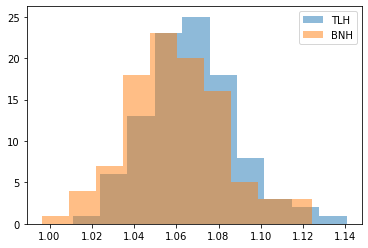

In [16]:
plt.hist(ret_TLH.get(), alpha = 0.5);
plt.hist(ret_BNH.get(), alpha = 0.5);
plt.legend(["TLH", "BNH"]);

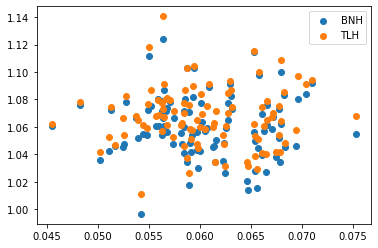

In [17]:
plt.scatter(risk.get(), ret_BNH.get())
plt.scatter(risk.get(), ret_TLH.get())
plt.legend(["BNH", "TLH"])